<a href="https://colab.research.google.com/github/sugi-san/anime_movie/blob/main/anime_movie_long.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

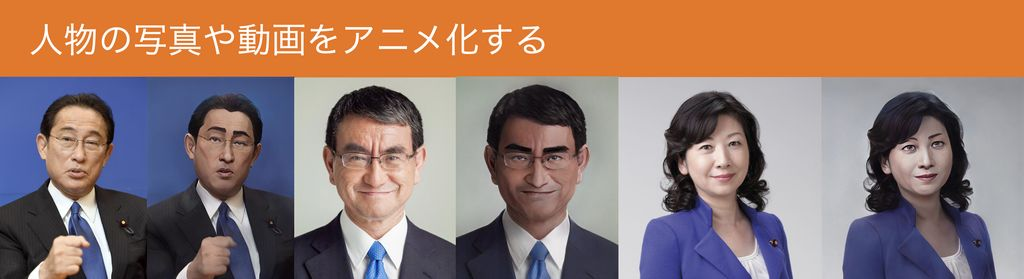

In [ ]:
#@title 1.セットアップ
# githubからコード取得
! git clone https://github.com/sugi-san/anime_movie.git

# 学習済みパラメータダウンロード
!wget https://github.com/Sxela/ArcaneGAN/releases/download/v0.4/ArcaneGANv0.4.jit
!pip -qq install facenet_pytorch


# ---- 初期設定&関数定義 ----
from facenet_pytorch import MTCNN
from torchvision import transforms
import torch, PIL
from tqdm.notebook import tqdm

mtcnn = MTCNN(image_size=256, margin=80)

# simplest ye olde trustworthy MTCNN for face detection with landmarks
def detect(img):
 
        # Detect faces
        batch_boxes, batch_probs, batch_points = mtcnn.detect(img, landmarks=True)
        # Select faces
        if not mtcnn.keep_all:
            batch_boxes, batch_probs, batch_points = mtcnn.select_boxes(
                batch_boxes, batch_probs, batch_points, img, method=mtcnn.selection_method
            )
 
        return batch_boxes, batch_points

# my version of isOdd, should make a separate repo for it :D
def makeEven(_x):
  return _x if (_x % 2 == 0) else _x+1

# the actual scaler function
def scale(boxes, _img, max_res=1_500_000, target_face=256, fixed_ratio=0, max_upscale=2, VERBOSE=False):
 
    x, y = _img.size
 
    ratio = 2 #initial ratio
 
    #scale to desired face size
    if (boxes is not None):
      if len(boxes)>0:
        ratio = target_face/max(boxes[0][2:]-boxes[0][:2]); 
        ratio = min(ratio, max_upscale)
        if VERBOSE: print('up by', ratio)

    if fixed_ratio>0:
      if VERBOSE: print('fixed ratio')
      ratio = fixed_ratio
 
    x*=ratio
    y*=ratio
 
    #downscale to fit into max res 
    res = x*y
    if res > max_res:
      ratio = pow(res/max_res,1/2); 
      if VERBOSE: print(ratio)
      x=int(x/ratio)
      y=int(y/ratio)
 
    #make dimensions even, because usually NNs fail on uneven dimensions due skip connection size mismatch
    x = makeEven(int(x))
    y = makeEven(int(y))
    
    size = (x, y)

    return _img.resize(size)

""" 
    A useful scaler algorithm, based on face detection.
    Takes PIL.Image, returns a uniformly scaled PIL.Image
    boxes: a list of detected bboxes
    _img: PIL.Image
    max_res: maximum pixel area to fit into. Use to stay below the VRAM limits of your GPU.
    target_face: desired face size. Upscale or downscale the whole image to fit the detected face into that dimension.
    fixed_ratio: fixed scale. Ignores the face size, but doesn't ignore the max_res limit.
    max_upscale: maximum upscale ratio. Prevents from scaling images with tiny faces to a blurry mess.
"""

def scale_by_face_size(_img, x_size, y_size, max_res=1_500_000, target_face=256, fix_ratio=0, max_upscale=2, VERBOSE=False):
    boxes = None
    boxes, _ = detect(_img)
    if VERBOSE: print('boxes',boxes)
    img_resized = scale(boxes, _img, max_res, target_face, fix_ratio, max_upscale, VERBOSE)
    return img_resized.resize((x_size, y_size))

size = 256
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

t_stds = torch.tensor(stds).cuda().half()[:,None,None]
t_means = torch.tensor(means).cuda().half()[:,None,None]

def makeEven(_x):
  return int(_x) if (_x % 2 == 0) else int(_x+1)

img_transforms = transforms.Compose([                        
            transforms.ToTensor(),
            transforms.Normalize(means,stds)])
 
def tensor2im(var):
     return var.mul(t_stds).add(t_means).mul(255.).clamp(0,255).permute(1,2,0)

def proc_pil_img(input_image, model):
    transformed_image = img_transforms(input_image)[None,...].cuda().half()
            
    with torch.no_grad():
        result_image = model(transformed_image)[0]; print(result_image.shape)
        output_image = tensor2im(result_image)
        output_image = output_image.detach().cpu().numpy().astype('uint8')
        output_image = PIL.Image.fromarray(output_image)
    return output_image

#load model
version = '0.4' 
model_path = f'/content/ArcaneGANv{version}.jit' 
in_dir = '/content/in'
out_dir = f"/content/{model_path.split('/')[-1][:-4]}_out"

model = torch.jit.load(model_path).eval().cuda().half()

#setup colab interface

from google.colab import files
import ipywidgets as widgets
from IPython.display import clear_output 
from IPython.display import display
import os
from glob import glob

def reset(p):
  with output_reset:
    clear_output()
  clear_output()
  process()
 
button_reset = widgets.Button(description="Upload")
output_reset = widgets.Output()
button_reset.on_click(reset)

def fit(img,maxsize=512):
  maxdim = max(*img.size)
  if maxdim>maxsize:
    ratio = maxsize/maxdim
    x,y = img.size
    size = (int(x*ratio),int(y*ratio)) 
    img = img.resize(size)
  return img
 
def show_img(f, size=1024):
  display(fit(PIL.Image.open(f),size))


# 画像表示関数
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

def display_pic(folder):
    fig = plt.figure(figsize=(20, 40))
    files = os.listdir(folder)
    files.sort()
    for i, file in enumerate(files):
        if file == '.ipynb_checkpoints':
          continue  
        img = Image.open(folder+'/'+file) 
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(file, fontsize=20)               
    plt.show()
    plt.close()


# 動画のサイズ取得 
def get_size(movie_file):

    # ffprobeで動画サイズをCSVファイルで取得
    ! ffprobe -v error -i $movie_file -select_streams v:0 -show_entries stream=width,height > movie.csv
    
    # csvファイルから動画サイズを取得
    import csv
    with open('movie.csv') as f:
        reader = csv.reader(f)
        for row in reader:
            if 'width' in row[0]:
               width = int(row[0][6:])
            if 'height' in row[0]:
               height = int(row[0][7:])
    return(width, height)


# サイズ調整関数
import cv2

def size_opt(file):
    max_size = 1024
    npyImage = cv2.imread(filename = file, flags = cv2.IMREAD_COLOR)
    intWidth = npyImage.shape[1]
    intHeight = npyImage.shape[0]

    fltRatio = float(intWidth) / float(intHeight)
    intWidth = min(int(max_size * fltRatio), max_size)
    intHeight = min(int(max_size / fltRatio), max_size)

    # ピクセルを偶数にする
    if not intWidth % 2 == 0:
      intWidth +=1
    if not intHeight % 2 ==0:
      intHeight +=1

    npyImage = cv2.resize(src=npyImage, dsize=(intWidth, intHeight), fx=0.0, fy=0.0, interpolation=cv2.INTER_AREA)
    cv2.imwrite(file, npyImage)


def process(x_size, y_size, upload=False):
  os.makedirs(in_dir, exist_ok=True)
  %cd {in_dir}/
  !rm -rf {out_dir}/*
  os.makedirs(out_dir, exist_ok=True)
  in_files = sorted(glob(f'{in_dir}/*'))
  if (len(in_files)==0) | (upload):
    !rm -rf {in_dir}/*
    uploaded = files.upload()
    if len(uploaded.keys())<=0: 
      print('\nNo files were uploaded. Try again..\n')
      return
  
  in_files = sorted(glob(f'{in_dir}/*'))
  for img in tqdm(in_files):
    out = f"{out_dir}/{img.split('/')[-1].split('.')[0]}.jpg"
    im = PIL.Image.open(img)
    im = scale_by_face_size(im, x_size, y_size, target_face=300, max_res=1_500_000, max_upscale=2)
    res = proc_pil_img(im, model)
    res.save(out)

  #out_zip = f"{out_dir}.zip"
  #!zip {out_zip} {out_dir}/*
    
  processed = sorted(glob(f'{out_dir}/*'))[:1]
  for f in processed: 
    show_img(f, 512)

! nvidia-smi -L

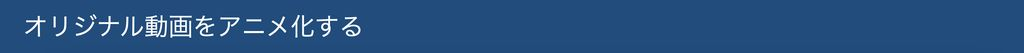

In [ ]:
#@title 2.動画のアップロード
import os
import shutil
from google.colab import files
import cv2

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートからpicフォルダーへ移動
for file in uploaded:
    #size_opt(file)  # サイズ調整して上書き
    #img = cv2.imread(filename = file, flags = cv2.IMREAD_COLOR)  # 上書きしたものを再読み込み
    shutil.move(file, './anime_movie/movies/'+file)  # 移動

#display_pic('pic')

In [ ]:
#@title 3.動画のアニメ化

# ---- 動画を静止画にバラす----
movie = '' #@param {type:"string"}
video_file = '/content/anime_movie/movies/'+movie
#@markdown ・動画はmp4音声付き（1280×720以下、20MB以下推奨）\
#@markdown ・変換時間は30秒で25分程度
# リセットファイル
if os.path.exists('/content/sound.mp3'):
   os.remove('/content/sound.mp3')

# 音声の抽出
! ffmpeg -y -i $video_file -loglevel error sound.mp3

import os
import shutil
import cv2

# inフォルダーリセット
%cd /content
if os.path.isdir('/content/in'):
    shutil.rmtree('/content/in')
os.makedirs('/content/in', exist_ok=True)
 
def video_2_images(video_file= video_file,   # ビデオの指定
                   image_dir='/content/in/', 
                   image_file='%s.jpg'):  

    # Initial setting
    i = 0
    interval = 1
    length = 10000  # 最大フレーム数
    
    cap = cv2.VideoCapture(video_file)
    fps = cap.get(cv2.CAP_PROP_FPS)  # fps取得

    while(cap.isOpened()):
        flag, frame = cap.read()  
        if flag == False:  
                break
        if i == length*interval:
                break
        if i % interval == 0:    
           cv2.imwrite(image_dir+image_file % str(int(i/interval)).zfill(6), frame)
        i += 1 
    cap.release()
    return fps, i, interval
 
fps, i, interval = video_2_images()
print('fps = ', fps)
print('flames = ', i)
print('interval = ', interval)


# ---- 静止画をアニメに変換 ----
x_size, y_size = get_size('/content/anime_movie/movies/'+movie)
process(x_size, y_size)
%cd /content
# コード内でカレントディレクトリを/content/inに移しているので、最後に/contentに戻す
# そうしないと、動画から静止画をバラすときに/content/inを一旦削除するためカレントディレクトリを見失うため


# ---- アニメから動画を作成 ----
# リセットファイル
if os.path.exists('/content/output.mp4'):
   os.remove('/content/output.mp4')
if os.path.exists('/content/out.mp4'):
   os.remove('/content/out.mp4')

# 動画作成
print('making movie...')
! ffmpeg -r $fps -i /content/ArcaneGANv0.4_out/%06d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error /content/output.mp4

# 音声の付加
print('adding sound...')
! ffmpeg -i output.mp4 -i sound.mp3 -loglevel error out.mp4

In [ ]:
#@title 4.アニメ動画のダウンロード
import shutil
from google.colab import files
shutil.copy('out.mp4', 'anime_'+movie)
files.download('anime_'+movie)